In [1]:
# pip install scikit-fuzzy

In [2]:
# pip install paho-mqtt

In [3]:
# Fuzzy logic and Controll dependencies
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Mathemathical dependencies
import numpy as np
import time

# MQTT dependencies
import paho.mqtt.client as mqtt
import localCredentials as creds

# UI dependencies
from IPython.display import display
from ipywidgets import widgets
import threading

In [4]:
# MQTT Broker
client = mqtt.Client(creds.client)
client.connect(creds.ip, creds.port, 60)

0

In [5]:
# Create Antecedent/Consequent objects for fuzzy controller
errotemp = ctrl.Antecedent(np.arange(-10, 10.1, 0.1), 'errotemp')
varerrotemp = ctrl.Antecedent(np.arange(-1, 1.01, 0.01), 'varerrotemp')
resfriador = ctrl.Consequent(np.arange(0, 101, 1), 'resfriador')

c:\Users\Diego AC\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


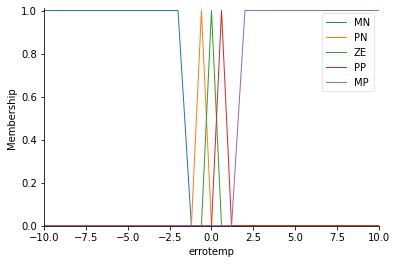

In [6]:
# Define membership functions for 'errotemp'
errotemp['MN'] = fuzz.trapmf(errotemp.universe, [-18, -18, -2, -1.2])
errotemp['PN'] = fuzz.trimf(errotemp.universe, [-1.2, -0.6, 0])
errotemp['ZE'] = fuzz.trimf(errotemp.universe, [-0.6, 0, 0.6])
errotemp['PP'] = fuzz.trimf(errotemp.universe, [0, 0.6, 1.2])
errotemp['MP'] = fuzz.trapmf(errotemp.universe, [1.2, 2, 18, 18])

# Display membership functions
errotemp.view()

c:\Users\Diego AC\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


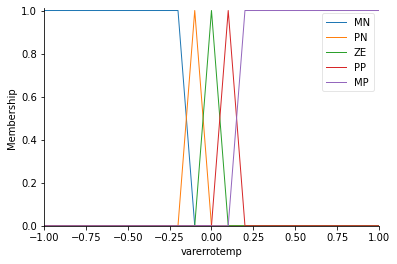

In [7]:
# Define membership functions for 'varerrotemp'
varerrotemp['MN'] = fuzz.trapmf(varerrotemp.universe, [-18, -18, -0.2,-0.1])
varerrotemp['PN'] = fuzz.trimf(varerrotemp.universe, [-0.2,-0.1,0])
varerrotemp['ZE'] = fuzz.trimf(varerrotemp.universe, [-0.1, 0, 0.1])
varerrotemp['PP'] = fuzz.trimf(varerrotemp.universe, [0, 0.1, 0.2])
varerrotemp['MP'] = fuzz.trapmf(varerrotemp.universe,[0.1, 0.2, 18, 18])

# Display 'varerrotemp' membership functions
varerrotemp.view()

c:\Users\Diego AC\AppData\Local\Programs\Python\Python310\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


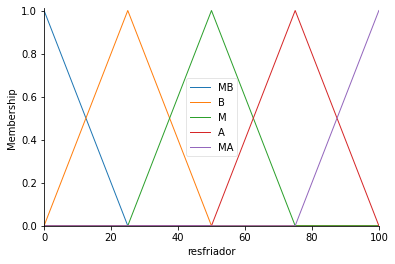

In [8]:
# Define membership functions for 'resfriador'
resfriador['MB'] = fuzz.trimf(resfriador.universe, [0,0,25])
resfriador['B'] = fuzz.trimf(resfriador.universe, [0,25,50])
resfriador['M'] = fuzz.trimf(resfriador.universe, [25, 50, 75])
resfriador['A'] = fuzz.trimf(resfriador.universe, [50, 75, 100])
resfriador['MA'] = fuzz.trimf(resfriador.universe, [75, 100, 100])

# Display 'resfriador' membership functions
resfriador.view()

In [9]:
# Define fuzzy rules for the controller. Each rule determines the output of the cooler ('resfriador')
# based on the temperature error ('errotemp') and the variation in temperature error ('varerrotemp').

regra1 = ctrl.Rule(errotemp['MN'] & varerrotemp['MN'], resfriador['MB'])
regra2 = ctrl.Rule(errotemp['PN'] & varerrotemp['MN'], resfriador['MB'])
regra3 = ctrl.Rule(errotemp['ZE'] & varerrotemp['MN'], resfriador['MB'])
regra4 = ctrl.Rule(errotemp['PP'] & varerrotemp['MN'], resfriador['A'])
regra5 = ctrl.Rule(errotemp['MP'] & varerrotemp['MN'], resfriador['M'])

regra6 = ctrl.Rule(errotemp['MN'] & varerrotemp['PN'], resfriador['MB'])
regra7 = ctrl.Rule(errotemp['PN'] & varerrotemp['PN'], resfriador['B'])
regra8 = ctrl.Rule(errotemp['ZE'] & varerrotemp['PN'], resfriador['B'])
regra9 = ctrl.Rule(errotemp['PP'] & varerrotemp['PN'], resfriador['A'])
regra10 = ctrl.Rule(errotemp['MP'] & varerrotemp['PN'], resfriador['A'])

regra11 = ctrl.Rule(errotemp['MN'] & varerrotemp['ZE'], resfriador['MB'])
regra12 = ctrl.Rule(errotemp['PN'] & varerrotemp['ZE'], resfriador['B'])
regra13 = ctrl.Rule(errotemp['ZE'] & varerrotemp['ZE'], resfriador['M'])
regra14 = ctrl.Rule(errotemp['PP'] & varerrotemp['ZE'], resfriador['A'])
regra15 = ctrl.Rule(errotemp['MP'] & varerrotemp['ZE'], resfriador['MA'])

regra16 = ctrl.Rule(errotemp['MN'] & varerrotemp['PP'], resfriador['B'])
regra17 = ctrl.Rule(errotemp['PN'] & varerrotemp['PP'], resfriador['B'])
regra18 = ctrl.Rule(errotemp['ZE'] & varerrotemp['PP'], resfriador['A'])
regra19 = ctrl.Rule(errotemp['PP'] & varerrotemp['PP'], resfriador['MA'])
regra20 = ctrl.Rule(errotemp['MP'] & varerrotemp['PP'], resfriador['MA'])

regra21 = ctrl.Rule(errotemp['MN'] & varerrotemp['MP'], resfriador['M'])
regra22 = ctrl.Rule(errotemp['PN'] & varerrotemp['MP'], resfriador['B'])
regra23 = ctrl.Rule(errotemp['ZE'] & varerrotemp['MP'], resfriador['MA'])
regra24 = ctrl.Rule(errotemp['PP'] & varerrotemp['MP'], resfriador['MA'])
regra25 = ctrl.Rule(errotemp['MP'] & varerrotemp['MP'], resfriador['MA'])

# Create a Control System using the defined rules
resfriador_ctrl = ctrl.ControlSystem([
    regra1, regra2, regra3, regra4, regra5, regra6, regra7, regra8, regra9,
    regra10, regra11, regra12, regra13, regra14, regra15, regra16, regra17,
    regra18, regra19, regra20, regra21, regra22, regra23, regra24, regra25
])

# Create a Control System Simulation to simulate the control system
potencia = ctrl.ControlSystemSimulation(resfriador_ctrl)

In [10]:
caption = widgets.Label(value='Selecione o modo de operação.')
dropdown = widgets.Dropdown(
    options=[('Armazenamento de Vacinas', -2), 
             ('Temperatura de mantimento fora de operação', -6), 
             ('Armazenamento de Amostras Biológicas', -8)],
    value=-2,
    description='Selecione:',
)

def handle_dropdown_change(change):
    caption.value = 'Operando em: ' + str(change.new) + 'ºC'
    global sp 
    sp = change.new

# Display the UI
display(caption, dropdown)
dropdown.observe(handle_dropdown_change, names='value')

Label(value='Selecione o modo de operação.')

Dropdown(description='Selecione:', options=(('Armazenamento de Vacinas', -2), ('Temperatura de mantimento fora…

In [11]:
# Setpoint and initial temperature
sp = 9
tempatual = 9
print(tempatual)

# Calculate initial temperature error
erroatual = tempatual - sp

def main_controller():
    global erroatual, tempatual
    while True:
        # Calculate error and error variation
        erroanterior = erroatual
        erroatual = tempatual - sp
        varerroTemp = erroatual - erroanterior
        
        # Input error and error variation into the control system
        potencia.input['errotemp'] = erroatual
        if (-1 < varerroTemp < 1): potencia.input['varerrotemp'] = varerroTemp
        else: potencia.input['varerrotemp'] = 0
        
        # Compute the output of the control system
        potencia.compute()
        
        # Update the temperature 10 times based on the output of the control system
        i = 0
        while (i < 10):
            tempatual = tempatual * 0.9952 - potencia.output['resfriador'] * 0.0003963
            time.sleep(0.1)
            i += 1
        
        # Print the current temperature, error, and error variation inline
        print('TEMP: {}\tERR: {}\tVAR ERR: {}'.format(tempatual, erroatual, varerroTemp), end='\r')

        # Publish the current temperature and error to the MQTT broker
        client.publish("Resfriador/Temperatura", tempatual)
        client.publish("Resfriador/erro", erroatual)

loop_thread = threading.Thread(target=main_controller)
loop_thread.start()

9
